In [31]:
import pandas as pd

# Load the datasets
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')




# Get the number of rows and columns for each DataFrame
rows_columns_X_train = X_train.shape
rows_columns_y_train = y_train.shape

# Output the number of rows and columns
print(f"X_train rows, columns: {rows_columns_X_train}")
print(f"y_train rows, columns: {rows_columns_y_train}")

X_train rows, columns: (10229, 26)
y_train rows, columns: (10229, 3)


In [35]:
# Merge the DataFrames on 'Identifiant'
df = pd.merge(X_train, y_train, on='Identifiant')
df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)
df.to_csv('merged_data.csv', index=False)

In [54]:
target = 'target'
labels = ['Claimed','Not Claimed']
features = [i for i in df.columns.values if i not in ["Identifiant", target]]


In [38]:
original_df = df.copy(deep=True)
display(df.head())
print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))


,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
0,18702,2014,1,0,V,N,1,O,1,O,...,V,base,2,1351.0,4,2012.0,0.0,2,65440,0
1,3877,2014,1,0,V,V,V,V,V,V,...,N,base,2,1972.0,2,1980.0,0.0,.,14341,1
2,4942,2013,1,1,V,V,V,V,V,V,...,N,base,2,1630.0,4,NaN,0.0,.,75109,0
3,13428,2013,"0,246575342",0,N,V,V,V,V,V,...,N,base,2,532.0,3,NaN,0.0,.,92004,0
4,17137,2015,1,0,V,N,2,O,1,O,...,V,base,2,1050.0,2,1972.0,0.0,4,59340,0



Inference: The Datset consists of 26 features & 10229 samples.


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10229 entries, 0 to 10228
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Identifiant  10229 non-null  int64  
 1   ft_2_categ   10229 non-null  int64  
 2   EXPO         10229 non-null  object 
 3   ft_4_categ   10229 non-null  int64  
 4   ft_5_categ   10229 non-null  object 
 5   ft_6_categ   10229 non-null  object 
 6   ft_7_categ   10229 non-null  object 
 7   ft_8_categ   10229 non-null  object 
 8   ft_9_categ   10229 non-null  object 
 9   ft_10_categ  10229 non-null  object 
 10  ft_11_categ  10229 non-null  object 
 11  ft_12_categ  10229 non-null  object 
 12  ft_13_categ  10229 non-null  object 
 13  ft_14_categ  10229 non-null  object 
 14  ft_15_categ  10229 non-null  object 
 15  ft_16_categ  10229 non-null  object 
 16  ft_17_categ  10229 non-null  object 
 17  ft_18_categ  10229 non-null  object 
 18  ft_19_categ  10229 non-null  int64  
 19  supe

In [42]:
#Checking the stats of all the columns

display(df.describe())

,Identifiant,ft_2_categ,ft_4_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,target
count,10229.000000,10229.000000,10229.000000,10229.000000,10110.000000,10229.000000,8993.000000,10229.000000
mean,9969.220745,2013.646789,0.281064,1.938508,1818.152918,2.238049,1965.061715,0.227002
std,5619.328018,1.380660,0.449540,0.240242,2272.111284,0.961589,33.548619,0.418914
min,0.000000,2012.000000,0.000000,1.000000,1.000000,1.000000,1545.000000,0.000000
25%,5198.000000,2012.000000,0.000000,2.000000,500.000000,2.000000,1960.000000,0.000000
50%,9820.000000,2013.000000,0.000000,2.000000,1002.000000,2.000000,1970.000000,0.000000
75%,14922.000000,2015.000000,1.000000,2.000000,2190.000000,3.000000,1980.000000,0.000000
max,19995.000000,2016.000000,1.000000,2.000000,30745.000000,4.000000,2016.000000,1.000000


In [40]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

target             2
ft_19_categ        2
ft_4_categ         2
ft_16_categ        2
ft_15_categ        2
ft_17_categ        3
ft_14_categ        3
ft_12_categ        3
ft_11_categ        3
ft_13_categ        3
ft_8_categ         3
ft_6_categ         3
ft_5_categ         3
ft_10_categ        3
ft_9_categ         4
ft_7_categ         4
ft_21_categ        4
ft_18_categ        5
ft_2_categ         5
ft_23_categ        7
ft_24_categ       11
ft_22_categ      139
EXPO             467
Insee           1525
superficief     2463
Identifiant    10229
dtype: int64

In [41]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 6 numerical & 19 categorical features.


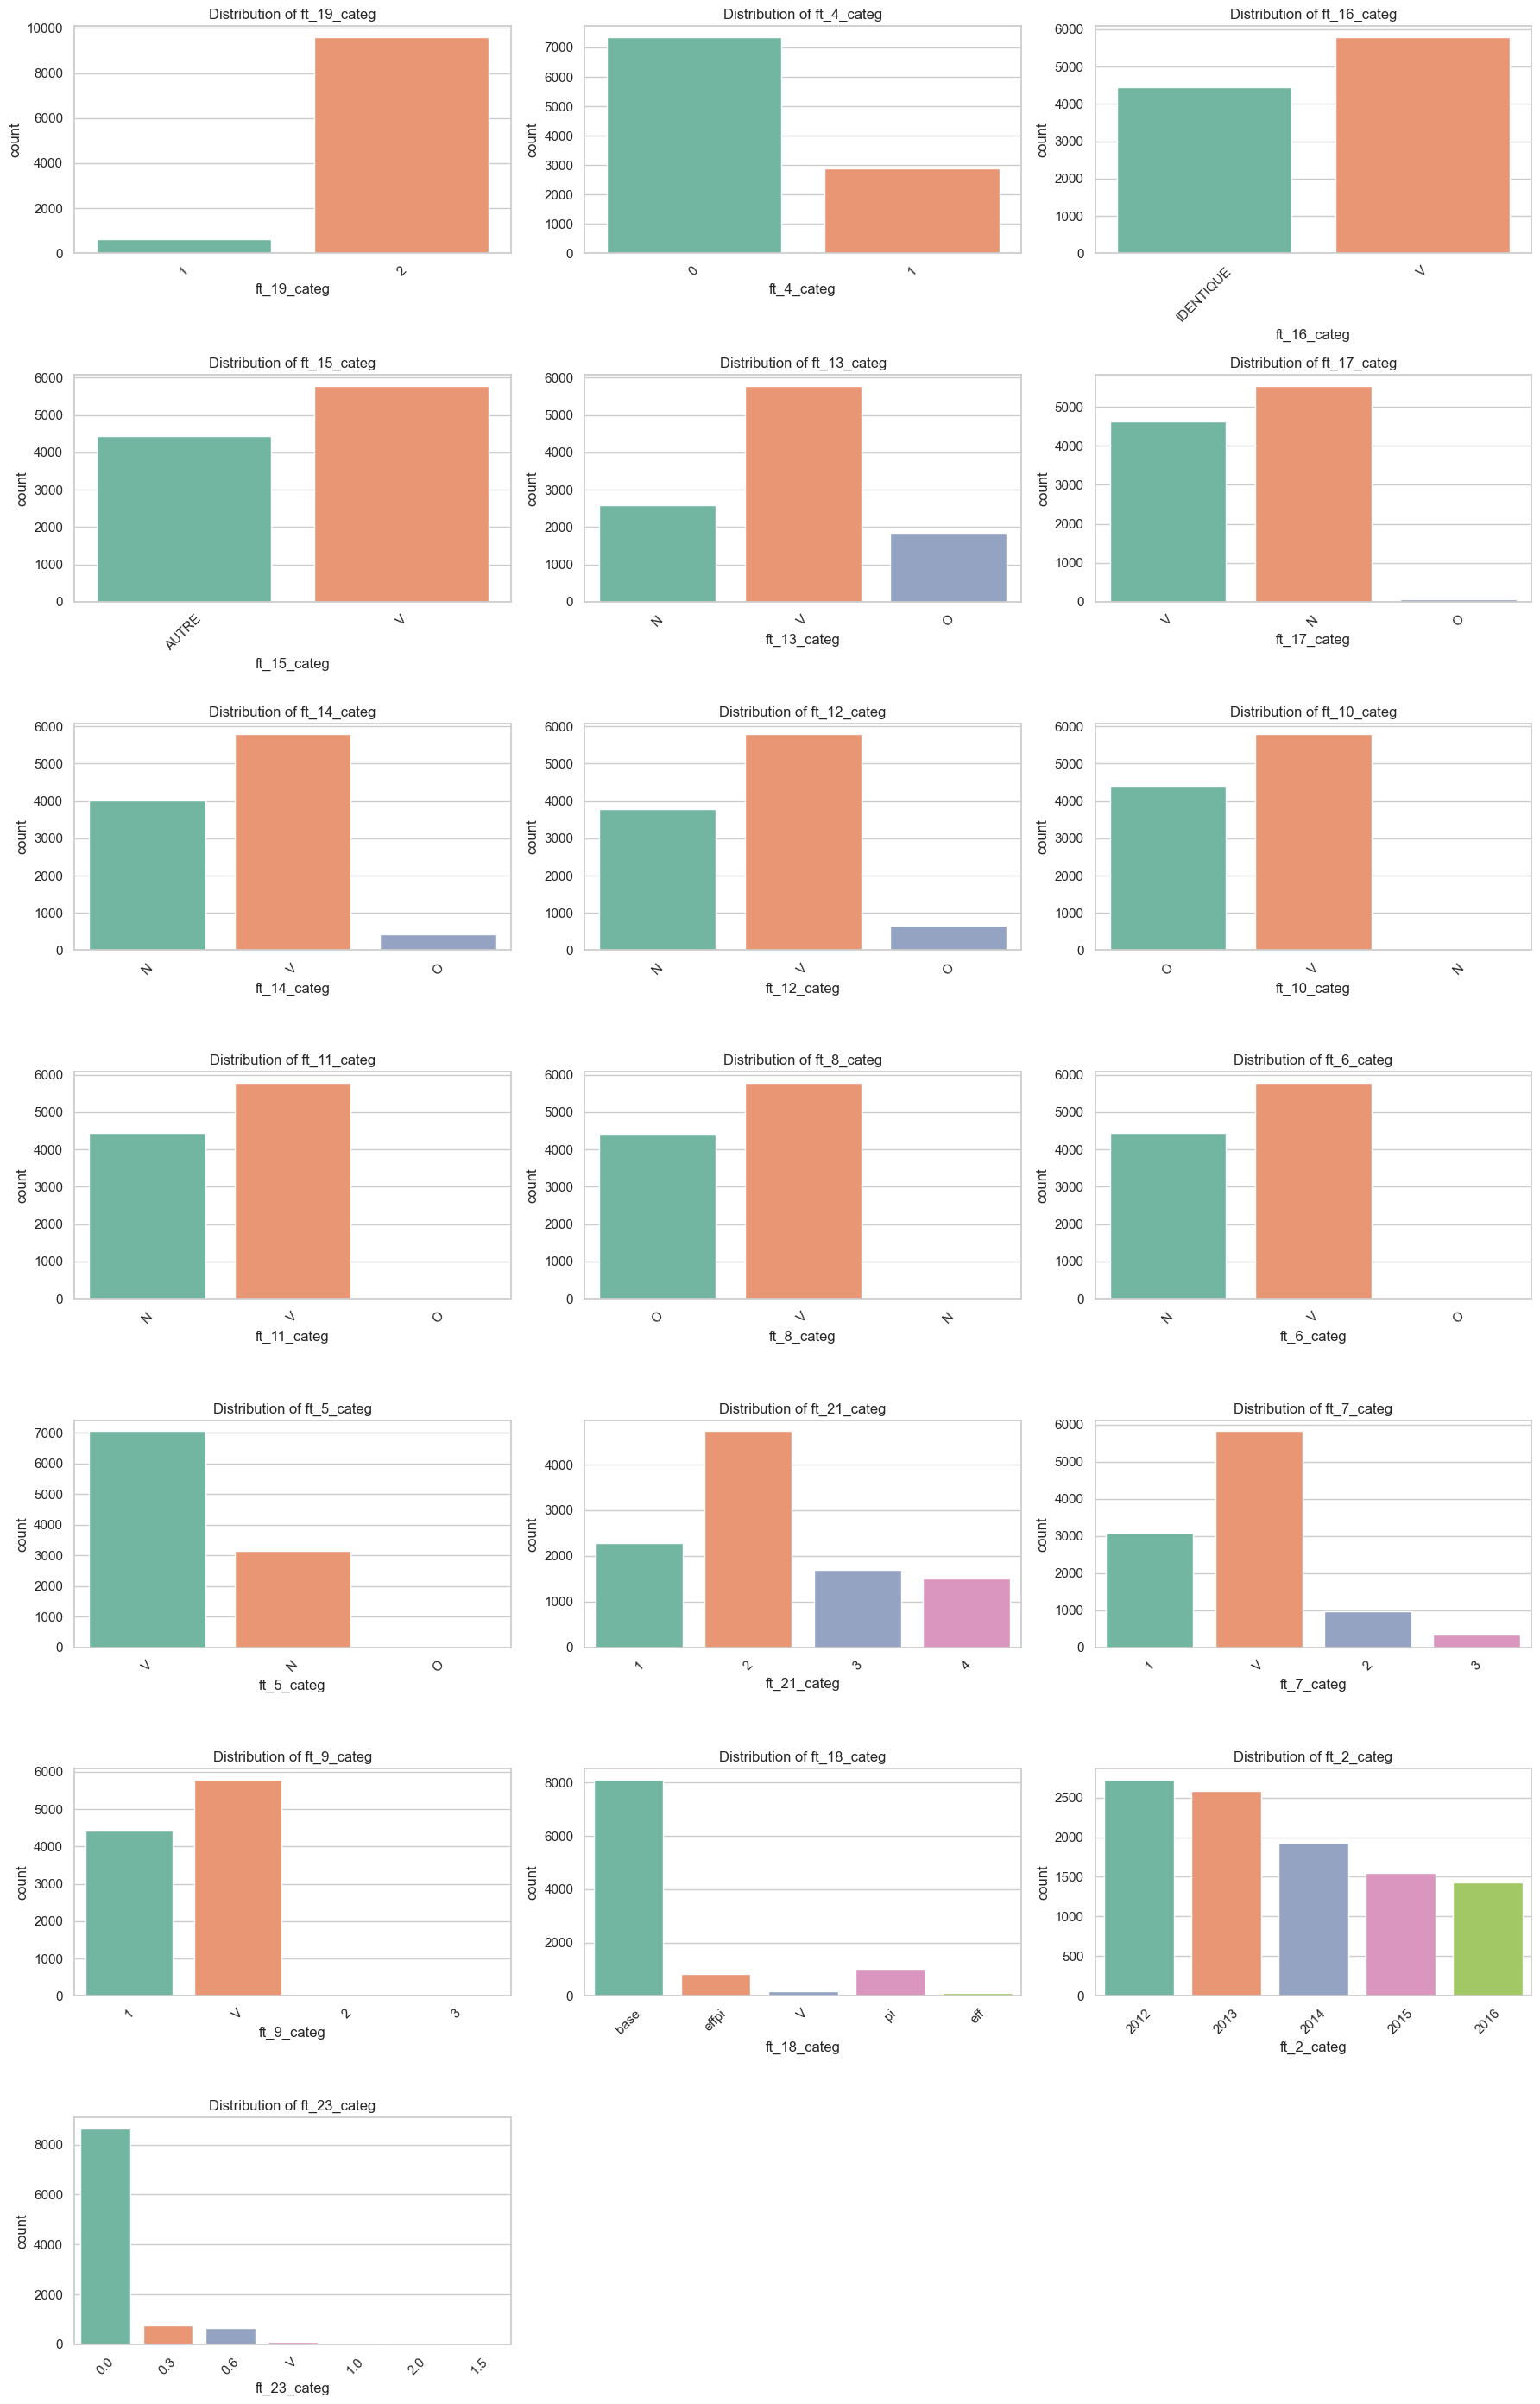

In [47]:

# Set the number of plots per row
plots_per_row = 3  # Adjust based on your preference and screen size

# Calculate the required number of rows to accommodate all categorical features
num_rows = len(cf) // plots_per_row + (len(cf) % plots_per_row > 0)

# Set the overall figure size
plt.figure(figsize=(18, num_rows * 4))  # Width, Height - adjust as needed

# Loop through the list of categorical features to create subplots
for i, feature in enumerate(cf):
    plt.subplot(num_rows, plots_per_row, i + 1)  # Rows, Columns, Plot number
    sns.countplot(x=feature, data=df, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)  # Rotate the labels to avoid overlap

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

In [50]:
import numpy as np
# Replace '   .' with np.nan across the entire DataFrame
df.replace('   .', np.nan, inplace=True)

# Optionally, convert columns to numeric, forcing non-convertible values to NaN
# This is useful if your DataFrame contains more hidden malformed strings
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

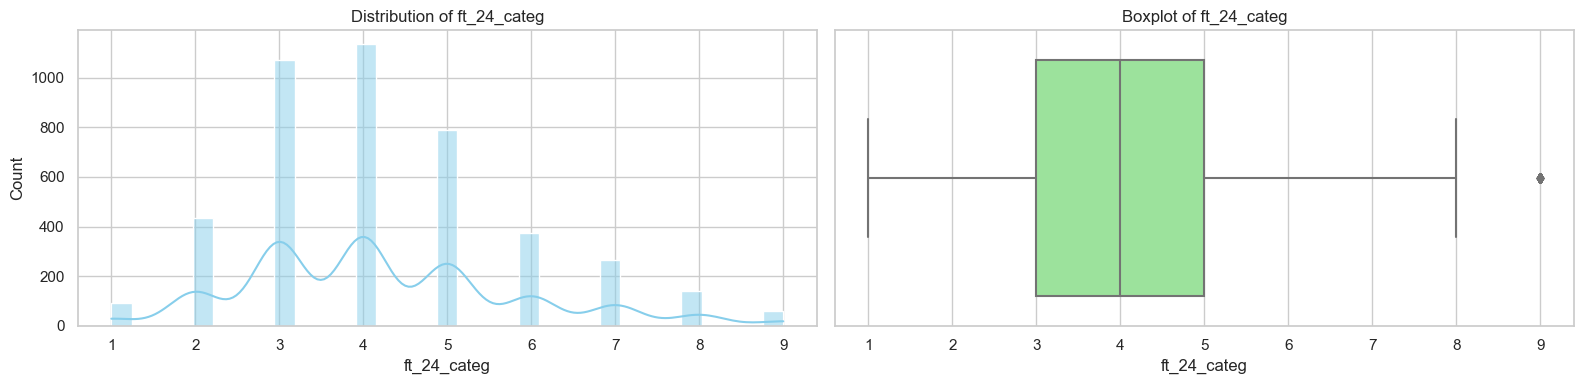

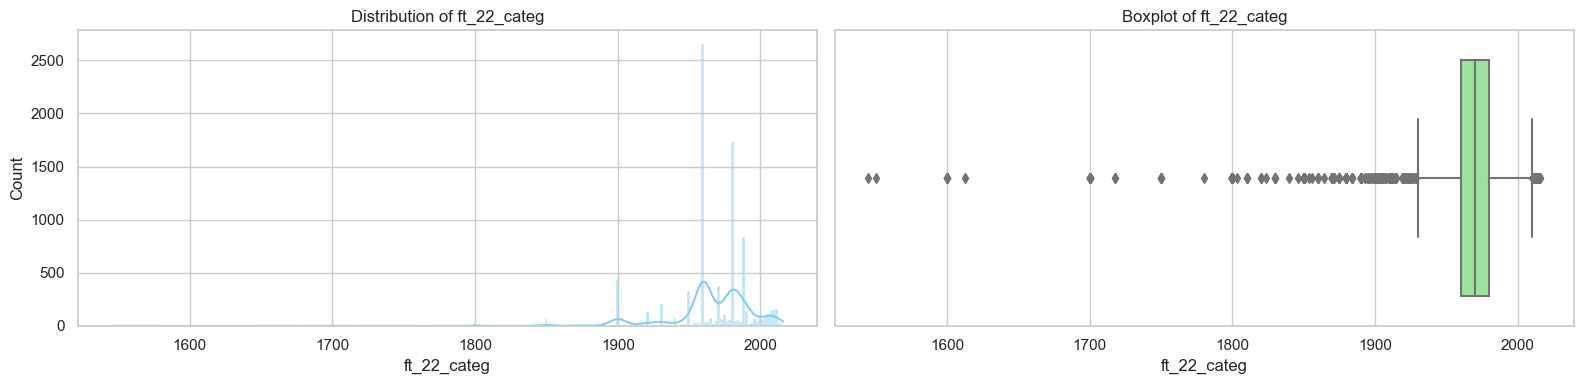

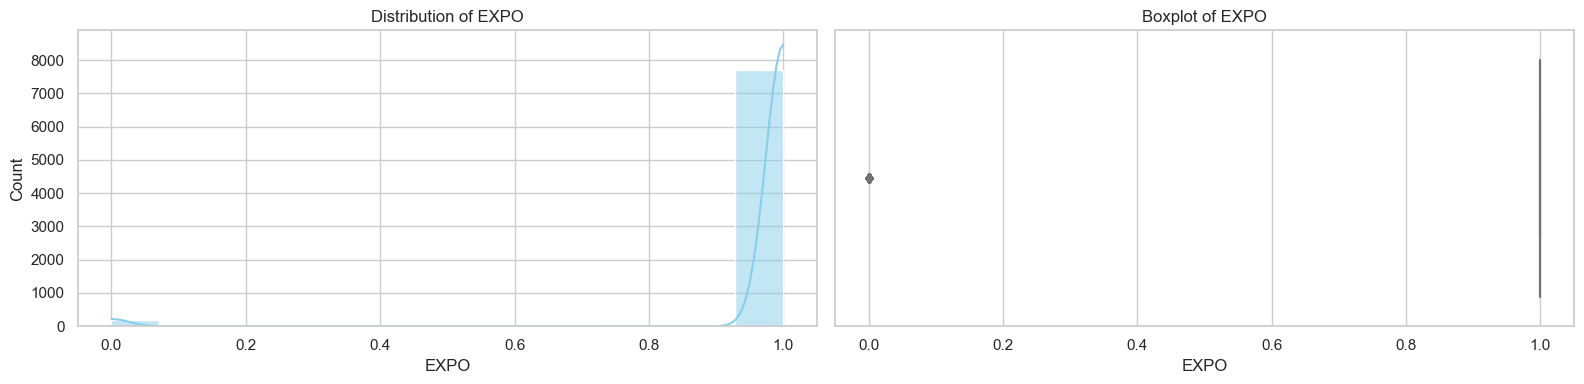

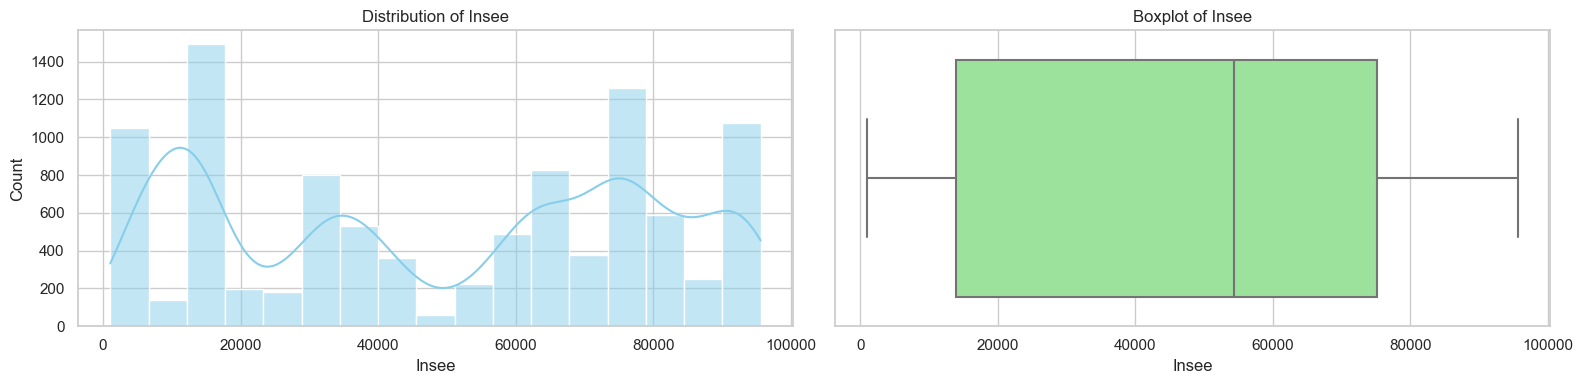

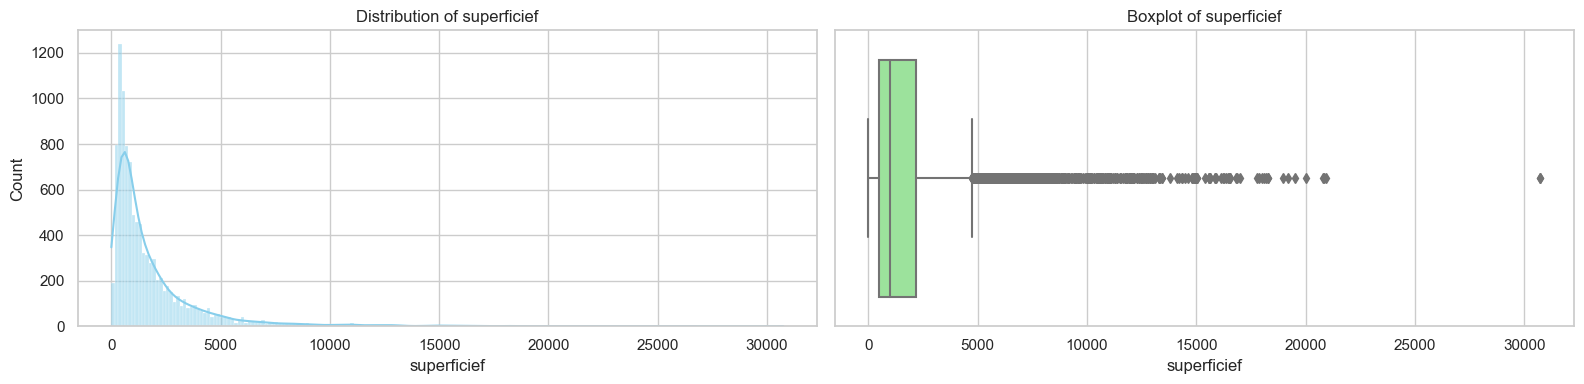

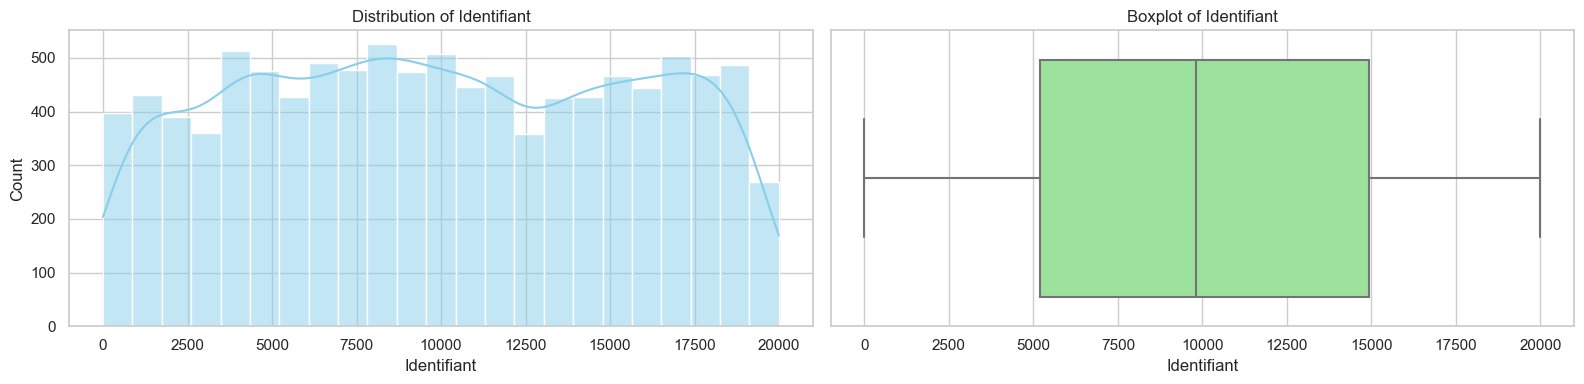

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'nf' contains your numerical features

for feature in nf:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    
    # Using histplot for distribution
    sns.histplot(df[feature].dropna(), ax=axes[0], color='skyblue', kde=True)
    axes[0].set_title(f'Distribution of {feature}')
    
    # Box Plot
    sns.boxplot(x=df[feature], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot of {feature}')

    plt.tight_layout()
    plt.show()


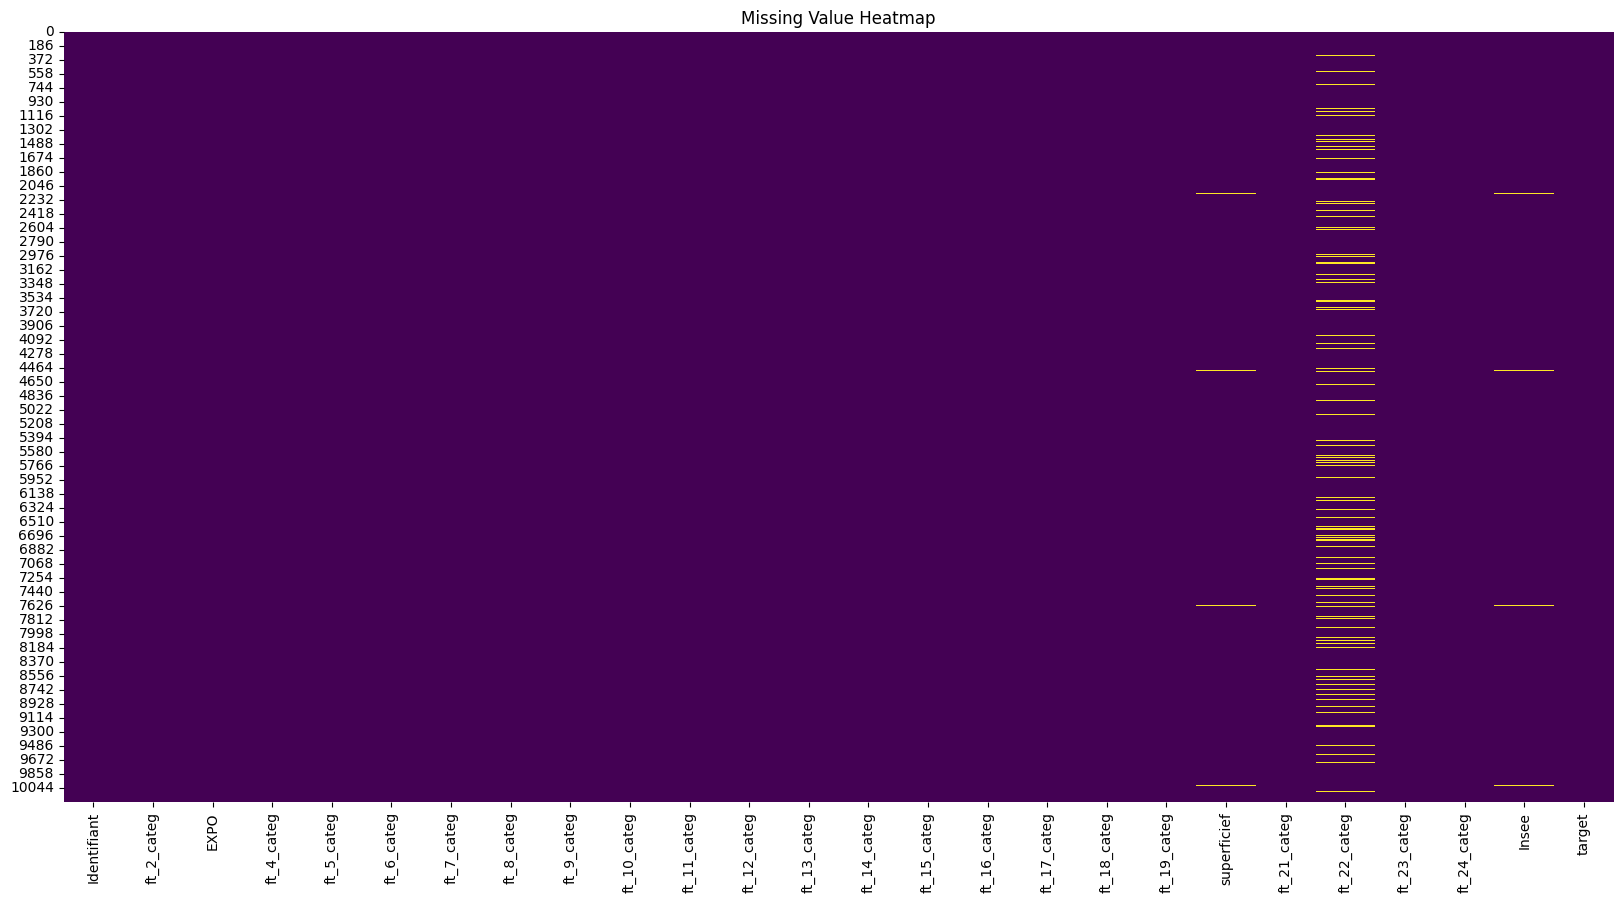

In [9]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your merged DataFrame
# Replace "." with NaN
merged_df = df.replace(".", pd.NA)

# Create a heatmap to visualize missing values
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

plt.title('Missing Value Heatmap')
plt.show()

In [11]:
for col in merged_df.columns:
    if merged_df[col].dtype == 'object':  # Only apply to columns with data type 'object'
        try:
            merged_df[col] = merged_df[col].str.replace(',', '.').astype(float)
        except ValueError:
            pass  # This column might contain non-numeric strings, so we pass


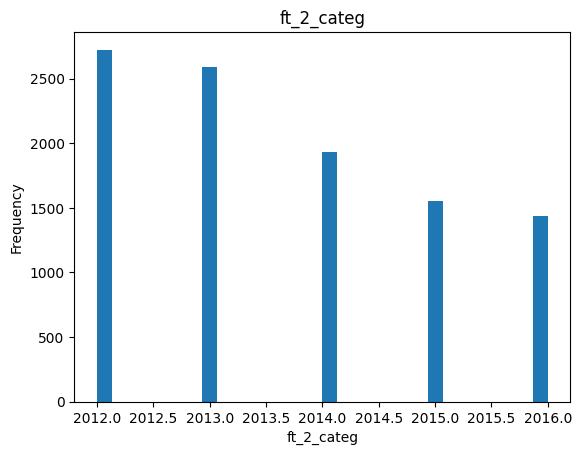

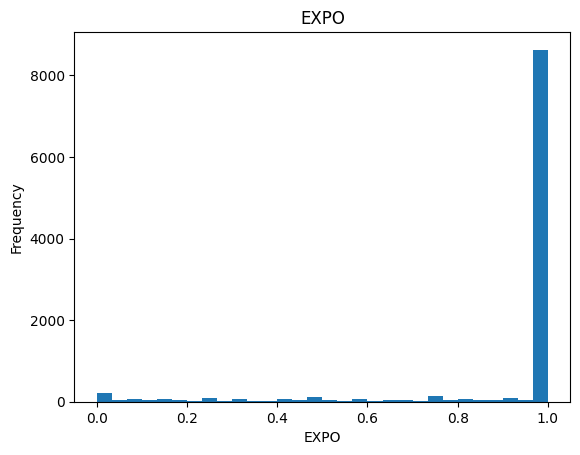

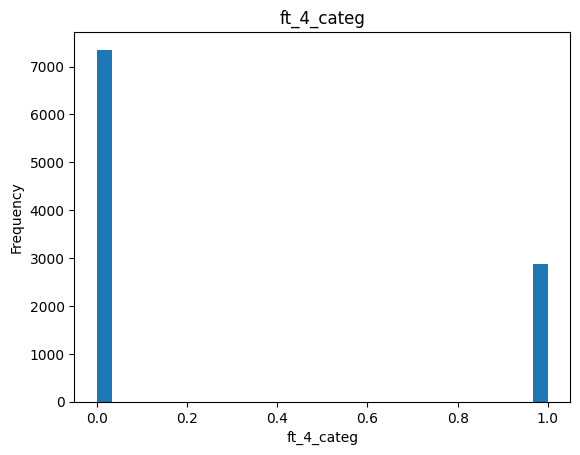

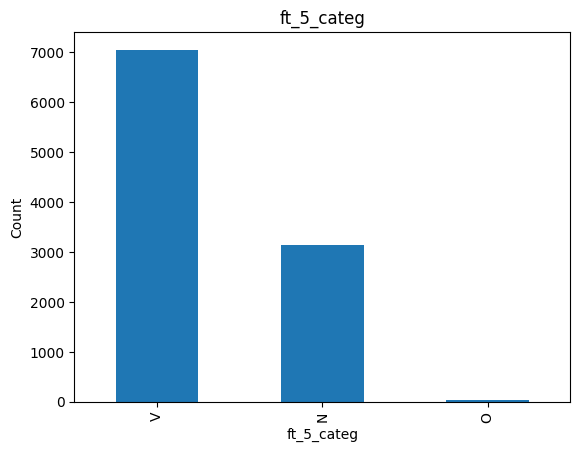

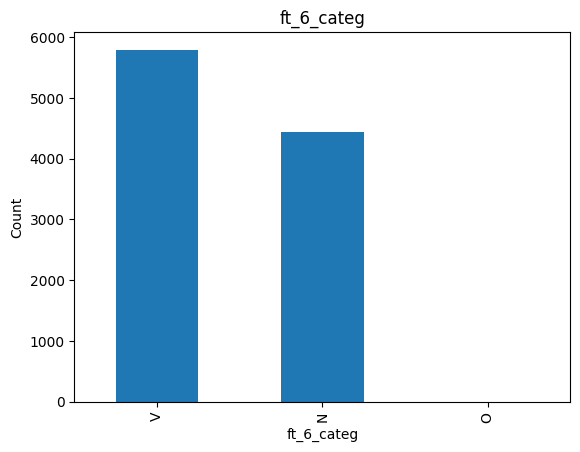

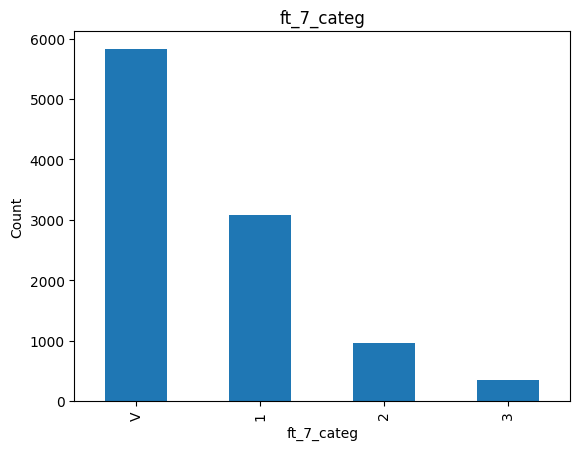

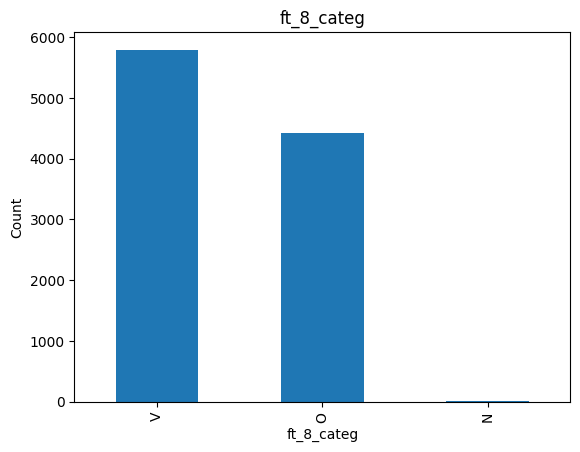

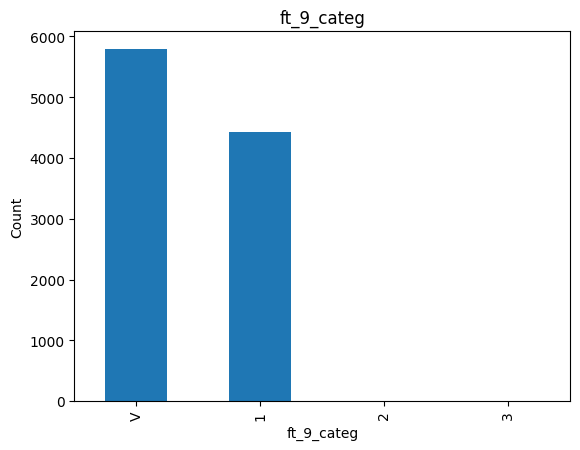

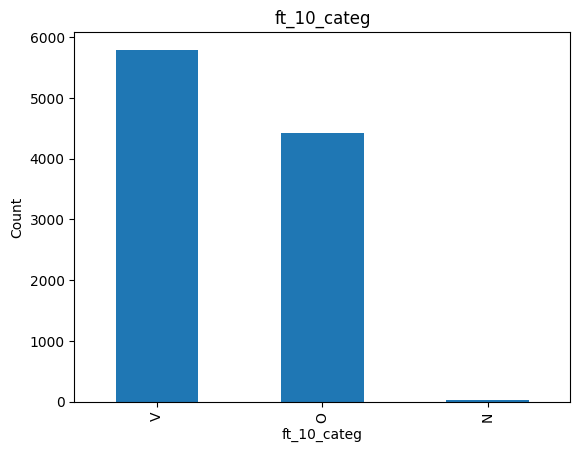

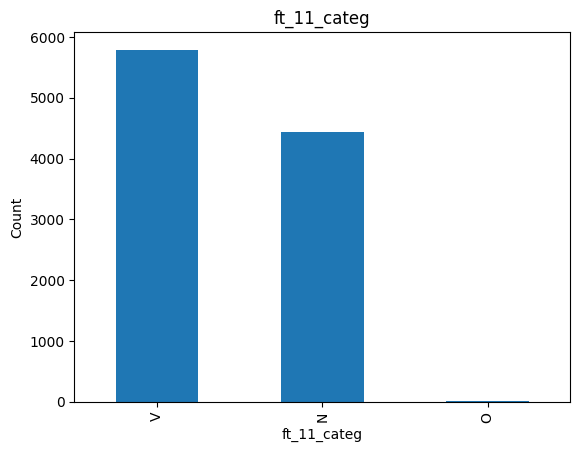

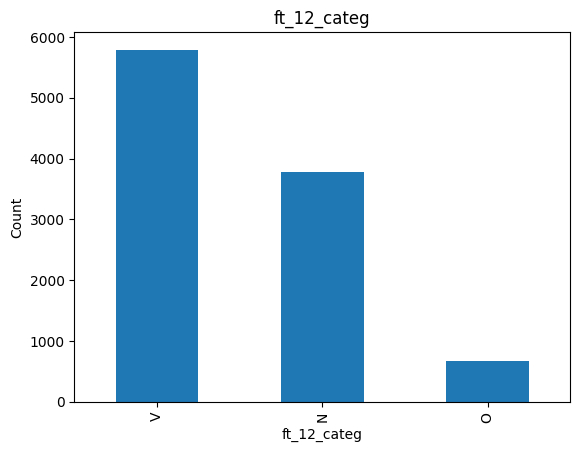

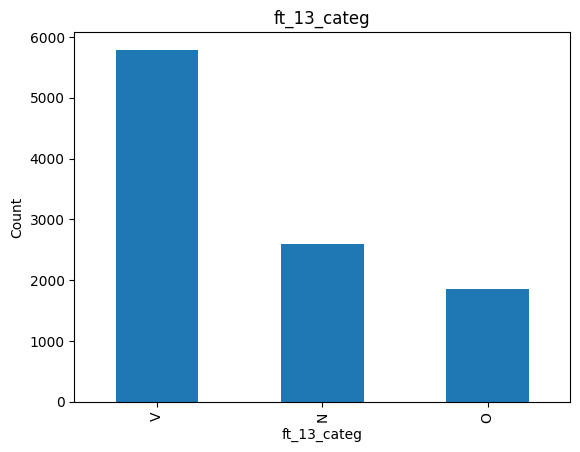

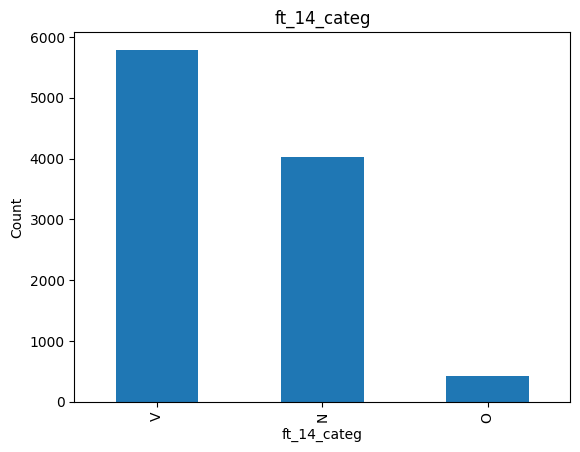

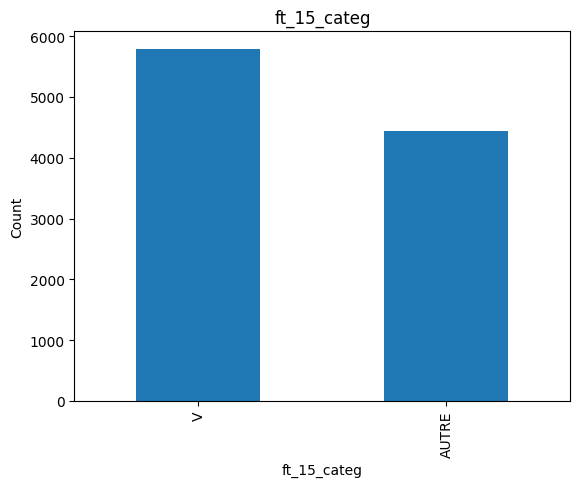

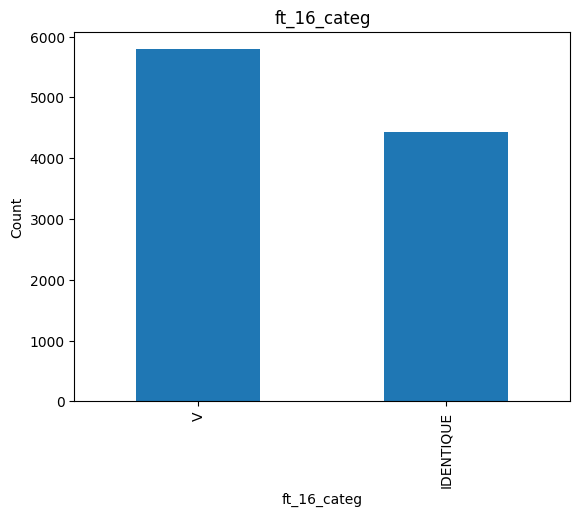

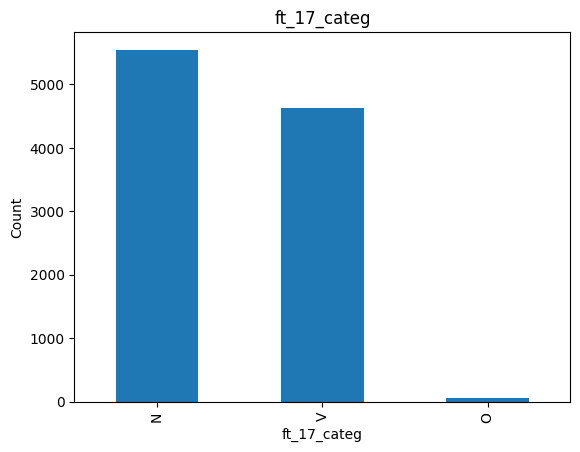

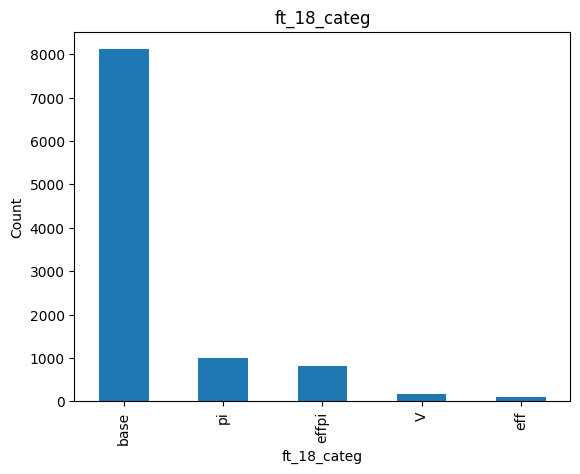

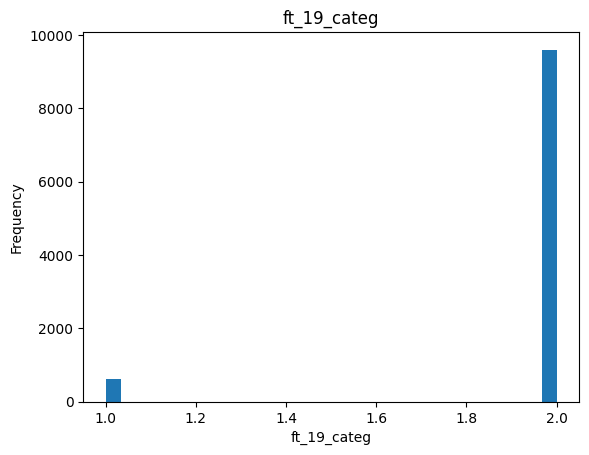

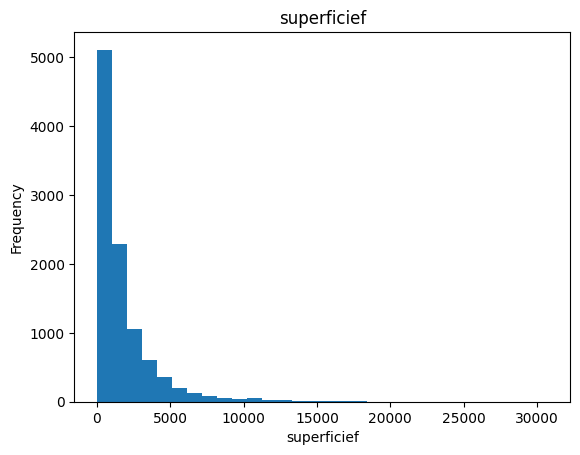

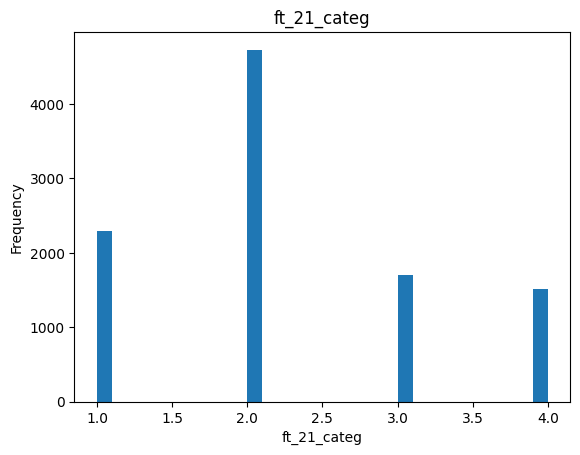

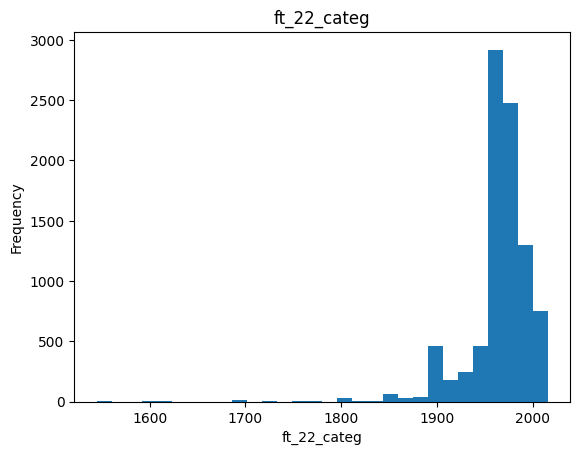

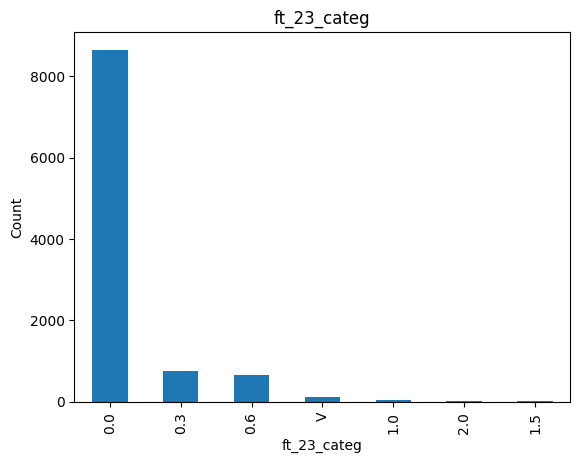

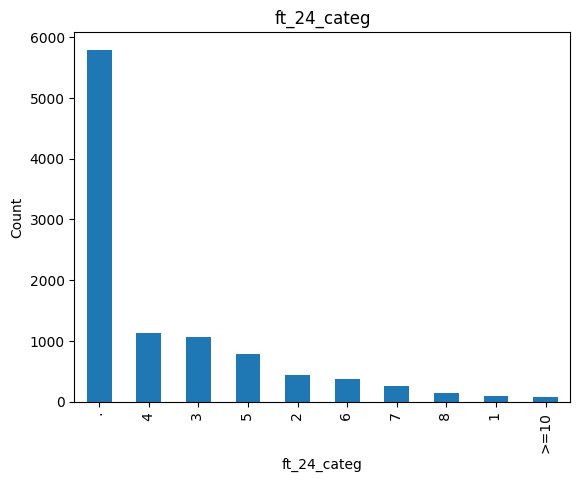

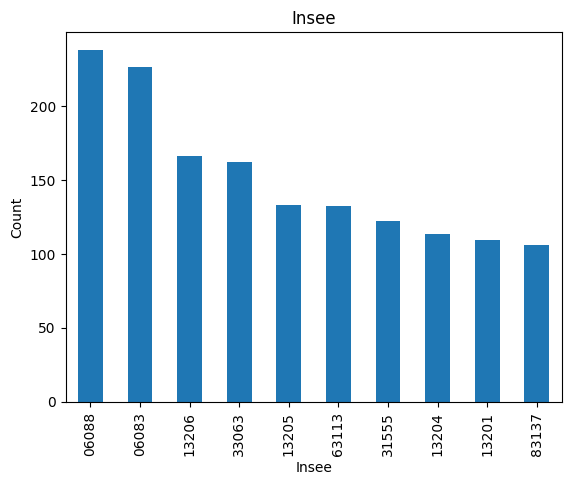

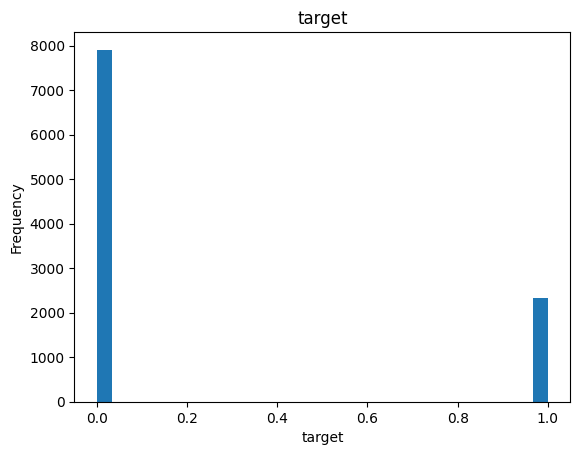

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame

# Iterate through each column in the DataFrame
for column in merged_df.columns:
    # Skip the 'Identifiant' column
    if column == 'Identifiant':
        continue
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(merged_df[column]):
        # Plot histogram for numeric columns
        merged_df[column].plot(kind='hist', bins=30, title=column)
        plt.xlabel(column)
        plt.ylabel('Frequency')
    else:
        # Plot bar chart for categorical columns
        # Because of potentially high cardinality, we limit to the top 10 values
        value_counts = merged_df[column].value_counts().nlargest(10)
        value_counts.plot(kind='bar', title=column)
        plt.xlabel(column)
        plt.ylabel('Count')
    
    plt.show()


In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10229 entries, 0 to 10228
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Identifiant  10229 non-null  int64  
 1   ft_2_categ   10229 non-null  int64  
 2   EXPO         10229 non-null  float64
 3   ft_4_categ   10229 non-null  int64  
 4   ft_5_categ   10229 non-null  object 
 5   ft_6_categ   10229 non-null  object 
 6   ft_7_categ   10229 non-null  object 
 7   ft_8_categ   10229 non-null  object 
 8   ft_9_categ   10229 non-null  object 
 9   ft_10_categ  10229 non-null  object 
 10  ft_11_categ  10229 non-null  object 
 11  ft_12_categ  10229 non-null  object 
 12  ft_13_categ  10229 non-null  object 
 13  ft_14_categ  10229 non-null  object 
 14  ft_15_categ  10229 non-null  object 
 15  ft_16_categ  10229 non-null  object 
 16  ft_17_categ  10229 non-null  object 
 17  ft_18_categ  10229 non-null  object 
 18  ft_19_categ  10229 non-null  int64  
 19  supe

In [16]:
#Checking number of unique rows in each feature

merged_df.nunique().sort_values()

target             2
ft_19_categ        2
ft_4_categ         2
ft_16_categ        2
ft_15_categ        2
ft_17_categ        3
ft_14_categ        3
ft_12_categ        3
ft_11_categ        3
ft_13_categ        3
ft_8_categ         3
ft_6_categ         3
ft_5_categ         3
ft_10_categ        3
ft_9_categ         4
ft_7_categ         4
ft_21_categ        4
ft_18_categ        5
ft_2_categ         5
ft_23_categ        7
ft_24_categ       11
ft_22_categ      139
EXPO             467
Insee           1525
superficief     2463
Identifiant    10229
dtype: int64

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
corr = merged_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()


ValueError: could not convert string to float: 'V'

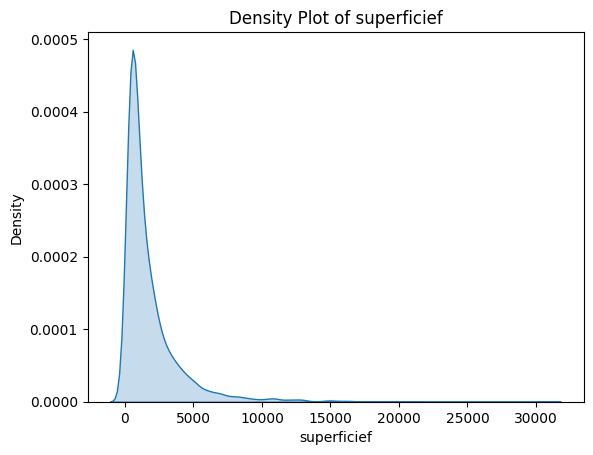

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example for plotting a density plot for a continuous column 'superficief'
sns.kdeplot(merged_df['superficief'], fill=True)
plt.title('Density Plot of superficief')
plt.xlabel('superficief')
plt.ylabel('Density')
plt.show()


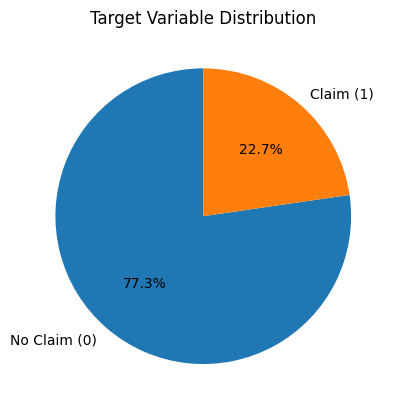

In [19]:
merged_df['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['No Claim (0)', 'Claim (1)'])
plt.title('Target Variable Distribution')
plt.ylabel('')  # Hide the y-label as it's not informative for a pie chart
plt.show()

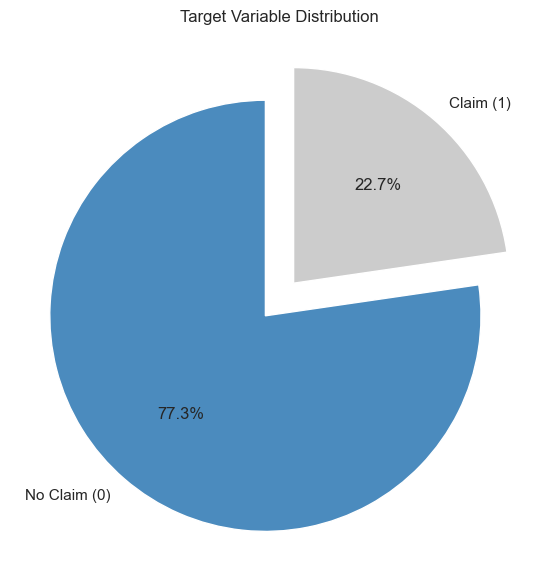

In [29]:
# Apply Seaborn's default styling
sns.set()

# Assuming 'merged_df' is your DataFrame and it has a 'target' column
target_counts = merged_df['target'].value_counts()

# Define labels
labels = ['No Claim (0)', 'Claim (1)']

# Explode settings to separate the slices a bit
explode = (0.1, 0.1)  # Slightly separate the slices

# Create the pie chart with Matplotlib
plt.figure(figsize=(7, 7))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode,
        colors = ['#4B8BBE', '#CCCCCC']  # Darker blue and grey
)

plt.title('Target Variable Distribution')
plt.show()

In [20]:
import pandas as pd

# Assuming 'merged_df' is your DataFrame and 'column_name' is the name of the column you're interested in
unique_values = merged_df['ft_19_categ'].unique()

# Print the unique values
print(unique_values)


[2 1]


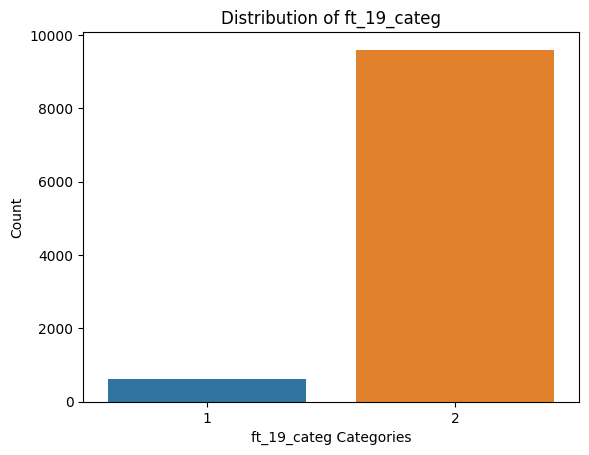

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='ft_19_categ', data=merged_df)
plt.title('Distribution of ft_19_categ')
plt.xlabel('ft_19_categ Categories')
plt.ylabel('Count')
plt.show()


target          0     1
ft_19_categ            
1             558    71
2            7349  2251


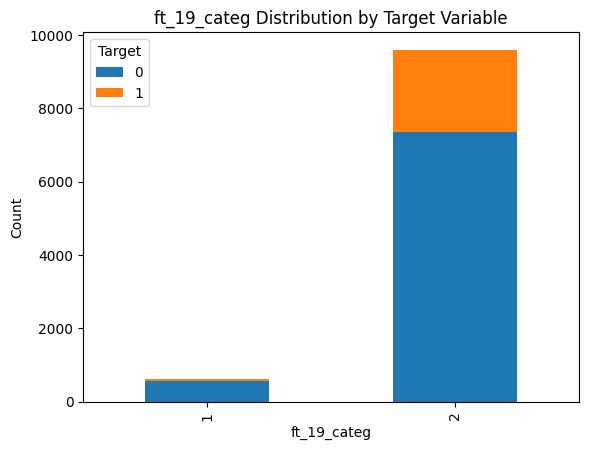

In [22]:
# Crosstab
ct = pd.crosstab(merged_df['ft_19_categ'], merged_df['target'])
print(ct)

# Stacked Bar Plot
ct.plot(kind='bar', stacked=True)
plt.title('ft_19_categ Distribution by Target Variable')
plt.xlabel('ft_19_categ')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()


In [23]:
from scipy.stats import chi2_contingency

# Chi-square test
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi-square test p-value: {p}")


Chi-square test p-value: 2.4881192683846114e-12
